In [1]:
import time
time.ctime()

'Fri Dec  8 22:07:23 2017'

Dieses IPython-Notebook basiert auf einer Beispiel-Rechnung als Ergänzung zur Dissertationsschrift von C. Knoll. Allgemeine Hinweise zu den Beispielen sind in der [readme.md-Datei des entsprechenden Repositoriums](https://github.com/cknoll/beispiele/blob/master/readme.md) zu finden.

Dieses Notebook benötigt folgende Module (am einfachsten per `pip install <modulname>` zu installieren):
* sympy
* https://github.com/TUD-RST/symbtools
* https://github.com/cknoll/ipydex


---

**Betrachtetes System**: Ein Pendel mit horizontal verschieblicher Aufhängung ("Wagen-Pendel-System")

￼ <img src="files/images/pendel_wagen.png">

**Inhalt**:
* Herleitung der Modellgleichungen in partiell linearisierter Form
* Transformation in Byrnes-Isidori-Normalform

**Bemerkung**

Das Notebook dient zur Demonstration, dass die rechenaufwendigen Transformationen sehr von einem Computer-Algebra-System (CAS) durchgeführt werden können. Im vorliegenden fall wird `sympy` als CAS verwendet. Im Paket `symbtools` und speziell in dessen Modul `modeltools` ist die Funktionalität für die Transformationen implementiert (Siehe dessen Quelltext).


[//]: # (custom_config_start)
$$
\newcommand{\d}{\mathrm{d}}
\newcommand{\col}{\mathrm{col}}
\newcommand{\bs}{\boldsymbol}
\newcommand{\Ddt}{\left(\tfrac{d}{dt}\right)}
\newcommand{\ddt}{\tfrac{d}{dt}}
$$
[//]: # (custom_config_end)

In [2]:
%load_ext ipydex.displaytools
%matplotlib inline

import sympy as sp
from sympy import sin, cos, pi
from sympy.interactive import printing
import pickle
from scipy.integrate import odeint

import symbtools as st
import symbtools.modeltools as mt
import symbtools.noncommutativetools as nct

zip0 = st.zip0
printing.init_printing(1)

In [3]:
t = sp.Symbol('t')
Np = 1
Nq = 1
n = Np + Nq
pp = st.symb_vector("p1:{0}".format(Np+1))
qq = st.symb_vector("q1:{0}".format(Nq+1))
aa = st.symb_vector("a1:{0}".format(Nq+1))
ww = st.symb_vector("w1:{0}".format(Nq+1))

ttheta = st.row_stack(pp, qq) ##:T
tthetad = st.time_deriv(ttheta, ttheta) ##:T
tthetadd = st.time_deriv(ttheta, ttheta, order=2) ##:T
st.make_global(ttheta, tthetad)

---


---


---


In [4]:
params = sp.symbols('m1, m2, s2, g')
st.make_global(params)

tau1 = sp.Symbol("tau1")

### Festlegung der Geometrie des mechanischen Systemes

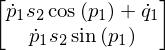

---


In [5]:
#Einheitsvektoren

ex = sp.Matrix([1,0])
ey = sp.Matrix([0,1])


# Koordinaten der Schwerpunkte und Gelenke

S1 = ex*q1 # Schwerpunkt Wagen
G2 = S1 # Pendel-Gelenk

# Schwerpunkt des Pendels (Pendel zeigt für kleine Winkel nach unten)
S2 = G2 + mt.Rz(p1)*(-ey)*s2

# Zeitableitungen der Schwerpunktskoordinaten
Sd1, Sd2  = st.col_split(st.time_deriv(st.col_stack(S1, S2), ttheta)) ##

In [6]:
# Energie
T_rot = 0 # (Punktmassenmodell)
T_trans = ( m1*Sd1.T*Sd1  +  m2*Sd2.T*Sd2 )/2

T = T_rot + T_trans[0]

V = m2*g*S2[1]

In [7]:
mod = mt.generate_symbolic_model(T, V, ttheta, [0, tau1])

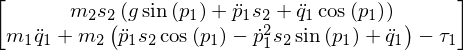

In [8]:
mod.eqns

In [9]:
mod.calc_state_eq()

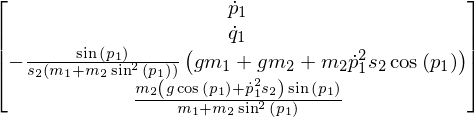

___


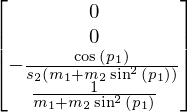

___


In [10]:
mod.f ##:
mod.g ##:

In [11]:
xx = st.symb_vector('x1:5') # Andere Symbole für Zustandskomponenten

# Latex-Code  für die Übung
st.adapted_latex(mod.f.subz(mod.xx, xx))
st.adapted_latex(mod.g.subz(mod.xx, xx))


\left(\begin{matrix}
x_{3}\\
x_{4}\\
- \frac{\sin x_{1} }{s_{2} \left(m_{1} + m_{2} \sin^{2} x_{1} \right)} \left(g m_{1} + g m_{2} + m_{2} s_{2} x_{3}^{2} \cos x_{1} \right)\\
\frac{m_{2} \left(g \cos x_{1}  + s_{2} x_{3}^{2}\right) \sin x_{1} }{m_{1} + m_{2} \sin^{2} x_{1} }
\end{matrix}\right)
% -------------
\left(\begin{matrix}
0\\
0\\
- \frac{\cos x_{1} }{s_{2} \left(m_{1} + m_{2} \sin^{2} x_{1} \right)}\\
\frac{1}{m_{1} + m_{2} \sin^{2} x_{1} }
\end{matrix}\right)
% -------------


In [12]:
mod.calc_coll_part_lin_state_eq()

# Benennung und Sortierung der Zustandskomponenten zu Übung / Vorlesung anpassen.
# Toolsbox modeltools benutzt aus $Gründen andere Konvention

zz = st.symb_vector('z1:5')
ww = st.symb_vector('w1:5')
st.make_global(xx, zz)

# Transformation von x nach z: z = Phi(x)
Phi = sp.Matrix([x2, x4, x1, x3])
J_Phi = Phi.jacobian(xx)

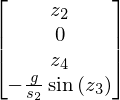

---


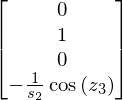

---


In [13]:
f_tilde = J_Phi * mod.ff.subz(mod.xx, xx).subz(Phi, zz) ##:
g_tilde = J_Phi * mod.gg.subz(mod.xx, xx).subz(Phi, zz) ##:

In [14]:
mod.calc_lbi_nf_state_eq()

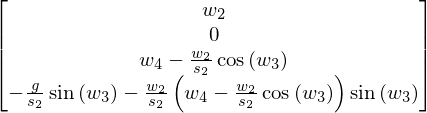

___


___


In [16]:
mod.fz.subz(mod.zz, ww) ##:
mod.gz.subz(mod.zz, ww) ##: